# Predictive coding of an two-dimensional signal in an multidimensional network

This notebook simulates an example network of 16 neurons encoding a two-dimensional signal.

## 1. Simulations

### a) Header definitions

Packages for simulating the network:

* math
* os
* sys
* Numpy
* Numpy.Random
* Numpy.Linalg
* statsmodels.api

In [2]:
### NATIVE
import math
import os
import sys

### NUMPY
import numpy as np
import numpy.random as rand
import numpy.linalg as LA

### STATS
import statsmodels.api as sm

### b) Functions to generate input signals

* **get_oscillat_input**: returns input signal running on a circle

In [3]:
def get_oscillat_input(time, ampl, freq, offs, noise_var = 0.0):
    ampl = ampl*np.ones(2) if isinstance(ampl, float) else ampl
    freq = freq*np.ones(2) if isinstance(freq, float) else freq
    offs = offs*np.ones(2) if isinstance(offs, float) else offs
    x       = np.zeros((2,len(time)))             # define input array
    x[:,:]  = [ ampl[0] * np.cos(freq[0]*time) + offs[0],  
                ampl[1] * np.sin(freq[1]*time) + offs[1]]  # periodic signal (2D circle)
    x[:,0]  = 0                                   # initial values
    x      += noise_var*rand.randn(2,len(time)) # adding zero-mean white noise
    return x

### c) Helper functions for neuron ablations and tuning curve estimation

In [4]:
def ablate_neuron(neuron, ts, F, W, V):
    """ Ablate i-th neuron at time step ts """
    print("Ablate neuron", neuron)
    F[neuron,:]  = 0
    W[neuron,:]  = 0
    W[:,neuron]  = 0
    V       = 0. 
    return F, W, V

def tuning_curves(t, x, r):
    lowess=[]
    angle = np.arctan2(x[1,t[0]:t[1]],x[0,t[0]:t[1]])
    for neuron in range(N):
        print("Neuron:", neuron)
        delta = (angle.max() - angle.min())*0.01
        temp = sm.nonparametric.lowess(r[neuron,t[0]:t[1]], angle, frac=0.1, delta = delta)
        lowess.append(temp)
    return lowess

### d) Function to run simulation

In [5]:
### Quick global options
_COST     = True                      # use quadratic cost term 
_VERBOSE  = False                     # Printout
_MULTI    = False                     # multiruns

def run(N, time, signal=0.0):
    """ This function simulates an N-dim. network for a given time
    
        RETURNS
        o      === spike trains of each neuron               || (nparray)
        st     === spike times and indices (for ISI)         || (nparray)
        V      === membrane potentials of each neuron        || (nparray)
        y      === spike trains of each neuron               || (nparray)
        r      === firing rates                              || (nparray)
        fr     === fast firing rates                         || (nparray)
        F      === feed-forward weights (ablated)            || (nparray)
        Fo     === initial feed-forward weights              || (nparray)
        W      === recurrent weights (ablated)               || (nparray)
        Wo     === initial recurrent weights                 || (nparray)
        D      === decoding weights (fixed)                  || (nparray)
        
        ARGS
        N      === number of neurons in network              || (int)
        time   === time array                                || (nparray)
        signal === input (default:0.0)                       || (float/nparray)
        
    """
    
    ### input dim (fixed=2) and time
    M  = 2                                                   # input dims
    dt = time[1]-time[0]                                     # integration time step
    T  = dt*len(time)                                        # total duration
    
    
    ### state containers
    V  = np.zeros((N,len(time)))                             # membrane potential
    o  = np.zeros((N,len(time)))                             # spike trains
    r  = np.zeros((N,len(time)))                             # firing rates
    fr = np.zeros((N,len(time)))                             # fast firing rates
    y  = np.zeros((M,len(time)))                             # readout
    st = []                                                  # spike times + index    
    
    
    ### input from args
    x  = signal                                              # input signal
    if isinstance(x, float):                                 # if float is given
        x *= np.ones((M,len(time)))                          # make sure input is correct dims
    
    
    ### network weights and firing threshold
    angles  = np.linspace(0, 2*np.pi, num=N, endpoint=False) # angles in [0,2PI) equally spaced
    angles += 0.00*2.*np.pi*rand.randn(N)
    
    ## FEED-FORWARD
    F       = np.array([np.cos(angles),np.sin(angles)]).T    # feed-forward connections
    F      *= 1.0                                            # scaling
    Fo      = np.copy(F)                                     # initial feed-forward weights
    
    ## RECURRENT
    mu      = mu_ext if _COST else 0.0                   # regularization constant (e-6)
    W       = F.dot(F.T) + mu * np.eye(N)                    # optimal weights
    W      *= 1.                                             # scaling
    Wo      = np.copy(W)                                     # initial recurrent weights
    
    ## DECODING
    D       = np.zeros((M,N))                                # decoder weights
    
    
    ### constant parameters
    Thr     = np.diag((F).dot(F.T))/2 + (mu/2)*np.ones(N)    # thresholds
    #Thr     = 0.5*np.ones(N)
    beta1   = 2*Thr - mu * np.ones(N)  
    leak = 1.                                                # leak constant
    
    if _VERBOSE:
        evals, evecs = LA.eigh(W)
        print("Feed-forward weights:", F)
        print("Recurrent weights:", W)
        print("Spectral radius:", evals)
        print("Threshold:", Thr)
     
    ### ablations
    nabl    = 4                                              # number of ablations
    tabl    = 1000.                                          # start of ablations
    ablen   = 0.5                                            # duration of ablations
    ablate_t= (np.arange(tabl, tabl+ablen, ablen/nabl))/dt        # ablation times (start at halftime in short window)
    ablate_t= ablate_t.astype(int)
    #ablate_t = []#[int(45.)/dt]
    if _VERBOSE:
        print("Ablations at t=", ablate_t*dt,"secs.")
    ablated = []
    to_ablate = []
    
    ### initial values
    V[:,0]  = -Thr
    
    ### running simulation
    if not _MULTI:
        print("Start simulation for", time[-1]+time[1],"seconds.")
    for i,t in enumerate(time[:-1]):
        
        ## ablations
        for ind, times in enumerate(ablate_t):
            if i == times:
                if len(to_ablate)==0:
                    rand_neuron = rand.randint(N)
                    while rand_neuron in ablated:
                        rand_neuron = rand.randint(N)
                else:
                    if ind < len(to_ablate):
                        rand_neuron = to_ablate[ind]
                if rand_neuron not in ablated:
                    F, W, V[:,i] = ablate_neuron(rand_neuron,i, F, W, V[:,i])
                    ablated.append(rand_neuron)
        
        ## input update
        c = x[:,i] + (x[:,i+1]-x[:,i])/dt                                      # neural input
        
        ## membrane potential update
        dV       = -V[:,i] + F.dot(c) - W.dot(o[:,i])                          # ODE membrane potential
        V[:,i+1] = V[:,i] + dt*leak*dV                                         # Euler integration
        
        ## spikes update
        o[:,i+1] = (V[:,i+1] > Thr)                                            # check for spikes
        if np.sum(o[:,i+1])>0:
            special_flake = rand.choice(np.ravel(np.nonzero(o[:,i+1])), 1)[0]  # look who's a special flake...
            o[:,i+1]      = np.eye(N)[special_flake]/dt                        # only one spike per time step
            st.append([t, special_flake])                                      # append spike time and index (ISI)
              
        ## firing rates update
        dr       = -r[:,i] + o[:,i+1]                                          # ODE firing rates
        r[:,i+1] = r[:,i] + dt*1.*dr                                           # Euler integration
        fr[:,i+1]= fr[:,i] + dt*2.*dr                                          # Faster rates for tuning curves
         
        ## regular printouts (every 10%)
        if math.fmod(100*t/T,10)==0 and not _MULTI:
            print(int(100*t/T), "%\t", "t:",t, "s")
            
    
    ### Calculate optimal decoding weights (decoding matrix from pseudoinv(F)*W)
    Finv1  = LA.pinv(Fo)
    Finv2  = LA.pinv(F)
    ablind = int(tabl/dt)
    #D = F.T
            
    ### Calculate readouts
    if tabl < T: 
        D1 = np.dot(Finv1,W_all[htime])
        D2 = np.dot(Finv2,W)
        y[:,:ablind]   = D1.dot(r[:,:ablind])
        y[:,ablind+1:] = D2.dot(r[:,ablind+1:])
    else:
        D  = np.dot(Finv2,W)
        D  = F.T
        y  = D.dot(r)
        
        
    ### Return
    if not _MULTI:
        print(100, "%\t", "t:",T, "s")
        print("Done.")
    return o, st, V, y, r, fr, F, Fo, W, Wo, D 

## 2. Experiments

### a) Simulation with circular input for 400 seconds

In [6]:
" Circular function input "
### simulation parameter
N    = 16                  # number of neurons
M    = 2                   # number of input dims
T    = 400.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array
np.random.seed(seed=42)    # comment if you want to get different random spiking
mu_ext = 0.1 ##0.000001/N

### ablations
ablate_t = []
ablated = []

### generate input signal
ampl = 5.
circ = get_oscillat_input(time, ampl, 1., 0.)                               # Circle
#circ = get_oscillat_input(time, ampl, np.array([1.,2.]), 0.)                 # Narrow eight
#circ = get_oscillat_input(time, np.array([ampl,0.5*ampl]), np.array([1.,2.]), 0.) # Wide eight
#circ = get_oscillat_input(time, np.array([0.,5.]), np.array([1.,2.]), 0.)  # Line

### run simulation
o, st, V, y, r, fr, ffW, ffWo, recW, recWo, decW = run(N, time, circ)

### tuning curves
tuning = tuning_curves([0, int(T/dt)], circ, fr)

### redefine for plotting
circ_o = o
circ_V = V
circ_y = y
circ_r = r
circ_fr = fr

Start simulation for 400.0 seconds.
0 %	 t: 0.0 s
10 %	 t: 40.0 s
20 %	 t: 80.0 s
30 %	 t: 120.0 s
40 %	 t: 160.0 s
50 %	 t: 200.0 s
60 %	 t: 240.0 s
70 %	 t: 280.0 s
80 %	 t: 320.0 s
90 %	 t: 360.0 s
100 %	 t: 400.0 s
Done.
Neuron: 0
Neuron: 1
Neuron: 2
Neuron: 3
Neuron: 4
Neuron: 5
Neuron: 6
Neuron: 7
Neuron: 8
Neuron: 9
Neuron: 10
Neuron: 11
Neuron: 12
Neuron: 13
Neuron: 14
Neuron: 15


### b) Simulations for different regularization factors $\mu$

mu = 0.0


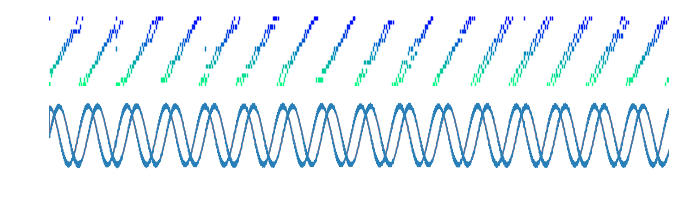

Mean Rate: 0.467712380269 +- 0.382040828152
Mean Error: 0.0521964811774 +- 0.000915808210126
mu = 0.01


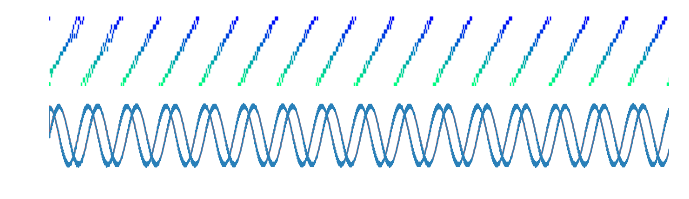

Mean Rate: 0.454576837443 +- 0.334347974105
Mean Error: 0.0495005902967 +- 0.00429914669044
mu = 0.02


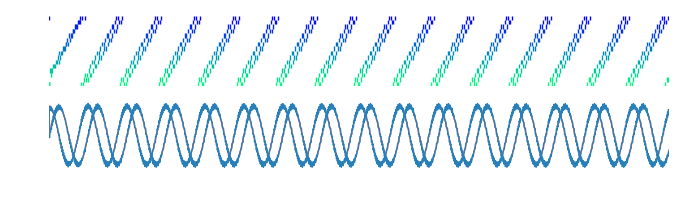

Mean Rate: 0.47726787755 +- 0.304597560559
Mean Error: 0.0566559005304 +- 0.000331189333583
mu = 0.1


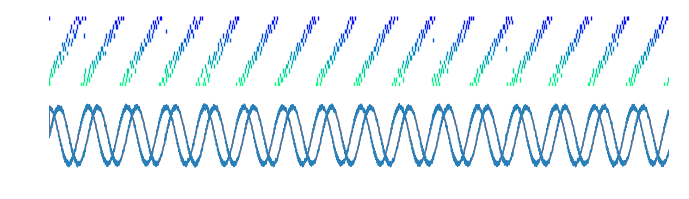

Mean Rate: 0.463811879038 +- 0.272171148628
Mean Error: 0.0732847880039 +- 0.000651716023633
mu = 0.2


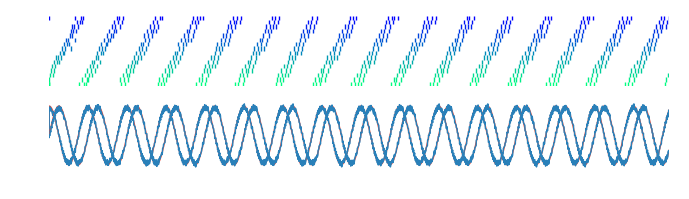

Mean Rate: 0.47204427438 +- 0.245551924694
Mean Error: 0.11140996374 +- 0.00222877364698
mu = 0.5


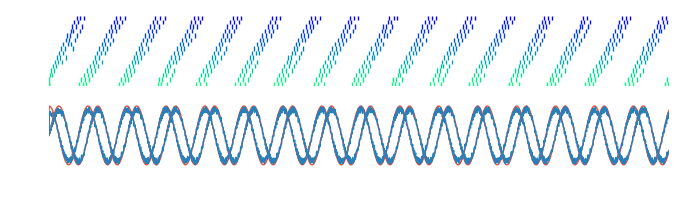

Mean Rate: 0.452964856764 +- 0.210211755821
Mean Error: 0.284247518279 +- 0.00126821059165
mu = 1.0


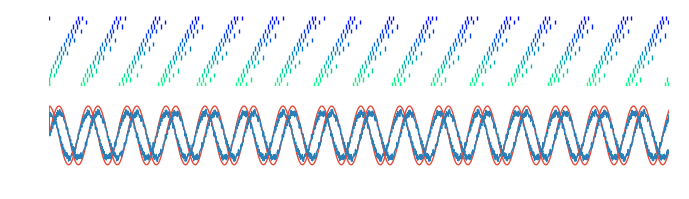

Mean Rate: 0.407659369932 +- 0.178288508108
Mean Error: 0.830106616281 +- 0.00266109609284
mu = 2.0


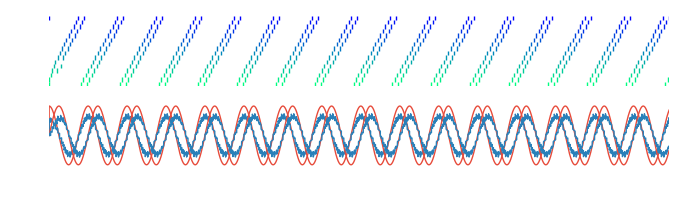

Mean Rate: 0.316326360775 +- 0.11988149953
Mean Error: 1.78697299392 +- 0.00178775103569
mu = 5.0


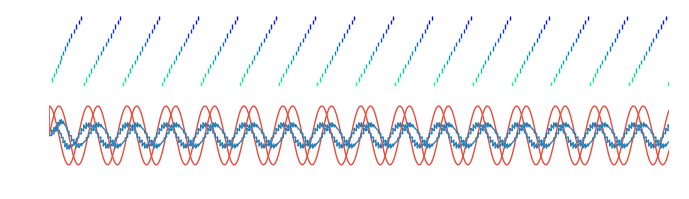

Mean Rate: 0.158378789529 +- 0.0543296627234
Mean Error: 5.23040193323 +- 0.0
mu = 10.0


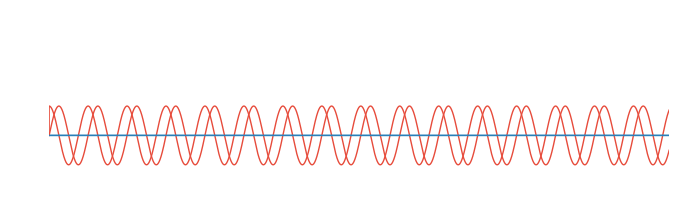

Mean Rate: 0.0 +- 0.0
Mean Error: 12.499875 +- 0.0


In [22]:
" Circular function input "
### simulation parameter
N    = 16                  # number of neurons
M    = 2                   # number of input dims
T    = 100.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array
np.random.seed(seed=42)    # comment if you want to get different random spiking
mu_ext = 0.1 ##0.000001/N
expos = np.arange(-6,2)
mus = [0.0, 0.01, 0.02, 0.1, 0.2,0.5, 1., 2., 5., 10.]

### ablations
ablate_t = []
ablated = []
### generate input signal
ampl = 5.
circ = get_oscillat_input(time, ampl, 1., 0.)                               # Circle
#circ = get_oscillat_input(time, ampl, np.array([1.,2.]), 0.)                 # Narrow eight
#circ = get_oscillat_input(time, np.array([ampl,0.5*ampl]), np.array([1.,2.]), 0.) # Wide eight
#circ = get_oscillat_input(time, np.array([0.,5.]), np.array([1.,2.]), 0.)  # Line

_MULTI = True
numtrials = 10
pop_rates = np.zeros((len(mus), numtrials))
pop_vars = np.zeros((len(mus), numtrials))
sq_errors = np.zeros((len(mus), numtrials))

for ind, imu in enumerate(mus):
    mu_ext = imu
    print("mu =", mu_ext)
    for trial in range(numtrials):
        np.random.seed(seed=42+trial)
        ### run simulation
        o, st, V, y, r, fr, ffW, ffWo, recW, recWo, decW = run(N, time, circ)
        
        if trial == numtrials-1:
            f, ax = plt.subplots(2, figsize=(8,2))
            ax[0] = rasterplot(ax[0], time, o*dt)
            ax[1].plot(time, circ[0], "-" , c=flatui['alizarin'])
            ax[1].plot(time, y[0], c=flatui['belize_hole'])
            ax[1].plot(time, circ[1], "-" , c=flatui['alizarin'])
            ax[1].plot(time, y[1], c=flatui['belize_hole'])
            ax[0].axis("off")
            ax[1].axis("off")
            plt.show()
        
        pop_rate = np.mean(r,axis=0)  # population activity
        pop_var  = np.var(r,axis=0)   # population variance
        sq_error = np.mean((circ-y)**2, axis=0)  # squared errors
        
        pop_rates[ind,trial] = np.mean(pop_rate)
        pop_vars[ind,trial] = np.mean(pop_var)
        sq_errors[ind,trial] = np.mean(sq_error)  
        if trial == numtrials-1:
            print("Mean Rate:", np.mean(pop_rates[ind]), "+-", np.mean(pop_vars[ind]))
            print("Mean Error:", np.mean(sq_errors[ind]), "+-", np.std(sq_errors[ind]))
            print("============")
                

## 3. Plotting

### a) Header definitions

Packages for plotting the results:

* matplotlib.pyplot
* matplotlib.legend_handler.HandlerLine2D
* matplotlib.image
* scipy.interpolate.UnivariateSpline
* svgutils.transform

Color definitions from FlatUI and rainbow colormap.

In [8]:
### MATPLOTLIB
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.image as mpimg
%matplotlib inline

### SCIPY
from scipy.interpolate import UnivariateSpline

import svgutils.transform as sg
from basic_units import radians, degrees, cos

### DEFINE COLORS (FLAT UI & RAINBOW)
flatui = {  'alizarin'   : "#e74c3c",
            'peter_river': "#3498db",
            'emerald'    : "#2ecc71",
            'sunflower'  : "#f1c40f",
            'carrot'     : "#e67e22",
            'amethyst'   : "#9b59b6",
            'turquoise'  : "#1abc9c",
            'wet_asphalt': "#34495e",
            'pomegranate': "#c0392b",
            'belize_hole': "#2980b9"
        }
rainbow = plt.get_cmap('rainbow', N)
winter = plt.get_cmap('winter_r', N)
summer = plt.get_cmap('summer_r', 10)
curcmap = winter

### b) General plotting function


Here we define plot functions used later in this notebook.

* **multiplot**: Takes an array of one-dimensional signals to be plotted (for time series in same plot).

* **rasterplot**: Creates a spike raster plot for given spike train and time array.

* **rasterplot_half**: Like rasterplot, but spikes are spaced (for placing membrane potential below). Option to add population spikes.

* **hide_ax**: Returns axes without right-upper borders.

* **ax_signal_space**:

* **ax_weight_space**:

* **plot_signal_weights**:

In [9]:
def multiplot(ax,x,arr):
    colors = curcmap
    for i, y in enumerate(arr):
        ax.plot(x, y, '-', c=colors(i))
    return ax

def rasterplot(ax, time, spikes):
    N = len(spikes)
    if N > 10:
        colors = winter
    else:
        colors = list(bcolors.values())
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        ax.vlines(time[spikes[neuron,:]==1], posy-0.5, posy+0.5, colors=colors(neuron))
    ax.set_ylim([0.5, N+0.5])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax

def rasterplot_half(ax, time, spikes, pos=[0.25, 0.6], pop=True):
    N = len(spikes)
    pop_spikes = np.sum(spikes, axis=0)
    dt = time[1]
    colors = curcmap
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        ax.vlines(time[spikes[neuron,:]==1], posy+pos[0], posy+pos[1], colors=colors(neuron), lw=2)
    if pop:        
        ax.vlines(time[pop_spikes==1], N+0.75, N+1.25, colors='k', lw=2)    
        ax.set_ylim([0, N+2])
    else:
        ax.set_ylim([0, N+1])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax


def hide_ax(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    return ax

def ax_signal_space(ax, x, y, scale, t):
    # data plotting
    ax.plot(y[0,t[0]:t[1]], y[1,t[0]:t[1]], c=flatui['belize_hole'], label="$\mathbf{y}(t)$")
    ax.plot(x[0,t[0]:t[1]], x[1,t[0]:t[1]], c=flatui['alizarin'], label="$\mathbf{x}(t)$")
    
    # legend/labels
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel("$x_1$", fontsize=12)
    ax.set_ylabel("$x_2$",rotation=0, fontsize=12)
    
    # scale/ticks
    sc = 1.2*scale
    ax.set_xlim([-sc,sc])
    ax.set_ylim([-sc,sc])
    tick=scale/2
    ax.set_xticks(np.arange(-scale,scale+tick,tick))
    ax.set_yticks(np.arange(-scale,scale+tick,tick))
    
    return ax

def ax_weight_space(ax, F, D, scale):
    # data plotting (only one goes to legend)
    for ind in range(N):
        if ind==0:
            ax.plot(F[ind,0], F[ind,1], 'o', mfc = curcmap(ind), mec='k', markersize=12, markeredgewidth=2, label='$(\mathbf{F}^T)_i$')
            ax.plot(D[0,ind], D[1,ind], 'o', mfc= curcmap(ind), mec='#bbbbbb', markersize=8, markeredgewidth=2, label='$\mathbf{D}_i$')
        else:
            ax.plot(F[ind,0], F[ind,1], 'o', mfc = curcmap(ind), mec='k', markersize=12, markeredgewidth=2)
            ax.plot(D[0,ind], D[1,ind], 'o', mfc= curcmap(ind), mec='#bbbbbb', markersize=8, markeredgewidth=2)        
        
    # legend/labels
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel("$D_1$", fontsize=12)
    ax.set_ylabel("$D_2$",rotation=0, fontsize=12)
    
    # scale/ticks
    sc = 1.2*scale
    ax.set_xlim([-sc,sc])
    ax.set_ylim([-sc,sc])
    tick=scale/2
    ax.set_xticks(np.arange(-scale,scale+tick,tick))
    ax.set_yticks(np.arange(-scale,scale+tick,tick))
    
    return ax

def plot_signal_weights(x, y, F, D, scalex, scaleF, t):
    f, ax = plt.subplots(2, figsize=(2.7,5))
    ax[0] = ax_signal_space(ax[0], x, y, scalex, t)
    ax[0].legend(bbox_to_anchor=(1.5, 1), ncol=1, frameon=False)
    ax[1] = ax_weight_space(ax[1], F, D, scaleF)
    ax[1].legend(bbox_to_anchor=(1.5, 1), ncol=1, numpoints=1, frameon=False, markerscale=0.75, handletextpad=-0.075)
    f.subplots_adjust(hspace = .4)
    return f, ax

def plot_time_series(time, x, y, V, o, r, t):
    ### Figure 2: time series
    figs = 2
    f, ax = plt.subplots(figs, 1, figsize=(5,2.5*figs),sharex=True)

    ### additional measures
    dt = time[1]
    pop_rate = np.mean(r,axis=0)  # population activity
    pop_var  = np.var(r,axis=0)   # population variance

    ### Row 0: spike raster plot
    ax[0] = rasterplot(ax[0], time[t[0]:t[1]], o[:,t[0]:t[1]]*dt)
    ax[0].set_ylabel("Neuron index", fontsize=12)
    
    ### Row 1: rates time series
    ax[1] = multiplot(ax[1], time, [rate for rate in r])
    ax[1].plot(time[t[0]:t[1]], pop_rate[t[0]:t[1]], "k-")
    ax[1].set_ylabel("Firing rates", fontsize=12)
    ax[1].set_xlabel("Time", fontsize=12)
    maxr = np.amax(r[:,t[0]:t[1]])
    minr = np.amin(r[:,t[0]:t[1]])
    ax[1].set_ylim([1.05*minr, 1.05*maxr])
    ax[1].set_yticks(np.arange(0, maxr, 1))
    
    f.subplots_adjust(hspace = .0)
    return f, ax

def plot_tuning(tuning):
    f, ax = plt.subplots(figsize=(5,3))
    pp = 200

    for neuron in range(N):
        ax.plot(tuning[neuron][::pp,0], tuning[neuron][::pp,1],".", markersize=2, c=curcmap(neuron))
    ax.set_xlabel("Angle [rad]", fontsize=12)
    ax.set_ylabel("Firing rate [Hz]", fontsize=12)
    ax.set_xlim([-np.pi, np.pi])
    tick = np.pi/4
    ax.set_xticks(np.arange(-np.pi, np.pi+tick, tick))
    ax.set_xticklabels(("$-\pi$","$-3\pi/4$","$-\pi/2$","$-\pi/4$","$0$", "$\pi/4$","$\pi/2$","$3\pi/4$","$\pi$"), fontsize=12)
    ymax = 1.05*np.amax(np.array(tuning))
    ax.set_yticks(np.arange(0, ymax, 1))
    ax.set_ylim([0,ymax])
    
    return f, ax

### c) Figure 2A: circular input (signal space: signals and weights)

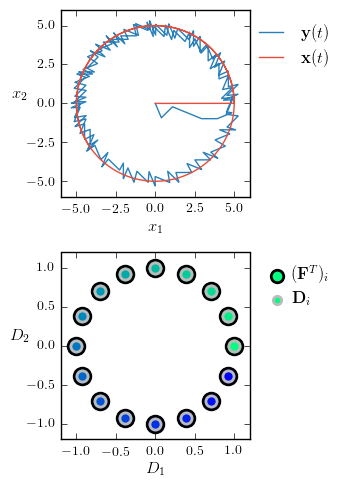

In [10]:
f, ax = plot_signal_weights(circ, circ_y, ffW, decW, ampl, 1., [0, int(10./dt)])
plt.tight_layout()
f.savefig("./plots/Fig2A.svg", dpi=900, bbox_inches='tight')
plt.show()

### d) Figure 2B: circular input (time series)

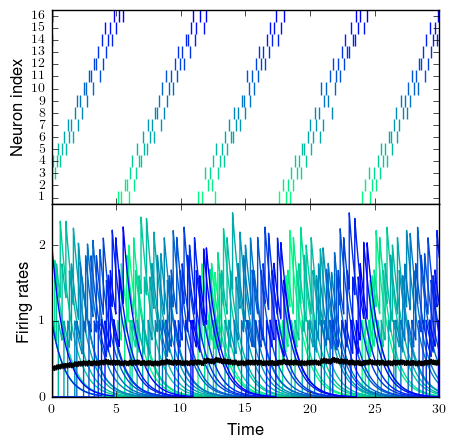

In [11]:
f, ax = plot_time_series(time, circ, circ_y, circ_V, circ_o, circ_r, [0, int(30./dt)])
plt.xlim([0,30.])
f.savefig("./plots/Fig2B.svg", dpi=900)
plt.show()

### e) Figure 2C: circular input (tuning curves)

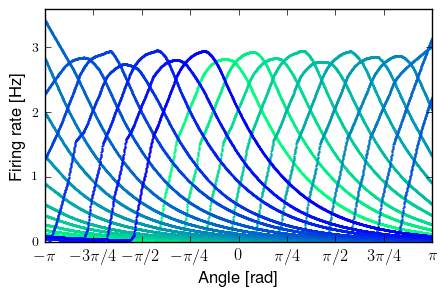

In [140]:
f, ax = plot_tuning(tuning)
f.savefig("./plots/Fig2C.svg", dpi=900)
plt.show()

### f) Figure 3: effect of $\mu$ on population rates, variance, and squared errors

[0.0, 0.01, 0.02, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


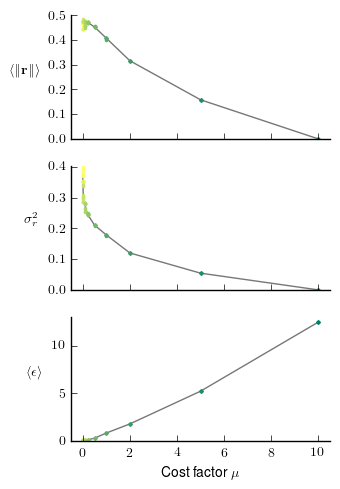

In [85]:
f, ax = plt.subplots(3, figsize=(3.5,5), sharex=True)
ax[0].plot(mus, np.mean(pop_rates,axis=1), "-" , c="#777777")
ax[1].plot(mus, np.mean(pop_vars,axis=1), "-" , c="#777777")
ax[2].plot(mus, np.mean(sq_errors,axis=1), "-" , c="#777777")
marks=2
for ind, mui in enumerate(mus):
    ax[0].plot(mui*np.ones(numtrials), pop_rates[ind], "o" , markersize=marks, mec=summer(ind) , mfc=summer(ind))
    ax[0].set_ylabel(r'${\langle} \|\mathbf{r}\| {\rangle} $', rotation='horizontal', labelpad=16)
    ax[1].plot(mui*np.ones(numtrials), pop_vars[ind], "o" ,markersize=marks, mec=summer(ind) , mfc=summer(ind))
    ax[1].set_yticks(np.arange(0,0.5,0.1))
    ax[1].set_ylabel(r'$\sigma^2_r$', rotation='horizontal', labelpad=12)
    ax[2].plot(mui*np.ones(numtrials), sq_errors[ind], "o" ,markersize=marks, mec=summer(ind) , mfc=summer(ind))
    ax[2].set_ylabel(r'${\langle} \epsilon {\rangle}$', rotation='horizontal', labelpad=12)
    ax[2].set_xlabel("Cost factor $\mu$")
    ax[2].set_ylim([0,13])
    ax[2].set_yticks(np.arange(0,15,5))
    for j in range(len(ax)):
        ax[j]=hide_ax(ax[j])
        ax[j].tick_params(axis=u'y', which=u'y',length=0.0)

plt.xlim([-0.5,10.5])
plt.tight_layout()
f.savefig("./plots/Fig3.pdf",dpi=900)
plt.show()

### 4. Join panels together into Figure 2 (using SVGs)

This cell could be put into a generic function using an array of files

Output size: 969px 362px


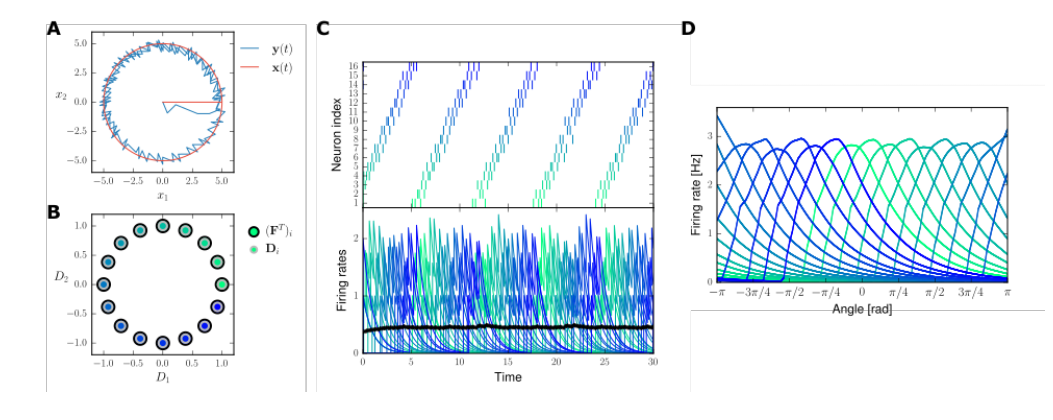

In [12]:
def toInt(string):
    return int(string.replace("pt", ""))

" join figures together "
#create new SVG figure
fig = sg.SVGFigure()

# load matpotlib-generated figures
curr_dir = "/Users/degoldschmidt/workspace/network-rotation/plots"
panels = [ sg.fromfile(curr_dir + "/Fig2A.svg"),
           sg.fromfile(curr_dir + "/Fig2B.svg"),
           sg.fromfile(curr_dir + '/Fig2C.svg')]

# get the plot objects and move them to right position
plots = []
sizes = []

for ind, panel in enumerate(panels):
    plots.append(panel.getroot())
    wid, hei = panel.get_size()
    sizes.append([toInt(wid), toInt(hei)])

plots[0].moveto(10, 10)
plots[1].moveto(sizes[0][0]+20, 10)
plots[2].moveto(sizes[1][0]+sizes[0][0], sizes[0][1]/2-sizes[2][1]/2)
newwid = sizes[0][0]+sizes[1][0]+sizes[2][0]

newwid = str(newwid)+"px"
newhei = str(sizes[0][1]+10)+"px"
print("Output size:",newwid, newhei)
fig.set_size([newwid, newhei])


# add text labels
fsize = 18
offs = 20
txtA = sg.TextElement(offs-10,offs, "A", size=fsize, weight="bold")
txtB = sg.TextElement(offs-10,offs+sizes[0][1]/2, "B", size=fsize, weight="bold")
txtC = sg.TextElement(offs+sizes[0][0],offs, "C", size=fsize, weight="bold")
txtD = sg.TextElement(offs-10+sizes[1][0]+sizes[0][0],offs, "D", size=fsize, weight="bold")


# append plots and labels to figure
fig.append([plots[2], plots[1], plots[0]])
fig.append([txtA, txtB, txtC, txtD])

# save generated SVG files
fig.save(curr_dir + "/Fig2.svg")
# svg-to-pdf conversion using Inkscape
inkscape = "/Applications/Inkscape.app/Contents/Resources/script --without-gui"
folder = "/Users/degoldschmidt/workspace/network-rotation/plots/"
filesvg = folder + "Fig2.svg"
filepdf = folder + "Fig2.pdf"
filepng = folder + "Fig2pre.png"
os.system(inkscape + " --export-pdf=" + filepdf + " " + filesvg)
os.system(inkscape + " --export-png=" + filepng + " " + filesvg)
# show preview png
plt.figure(figsize=(13,5))
image = mpimg.imread(filepng)
plt.imshow(image)
plt.axis("off")
plt.show()